In [ ]:
# Audio processing library
import librosa
import numpy as np
import pandas as pd
import os
import itertools
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
# Only use raw audio files to extract features by hand
base_path = '...'

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelEncoder

In [4]:
col_names = [
    'file_name',
    'genre',
    'stft_mean_0', 'stft_std_0',
    'stft_mean_1', 'stft_std_1',
    'stft_mean_2', 'stft_std_2',
    'stft_mean_3', 'stft_std_3',
    'stft_mean_4', 'stft_std_4',
    'stft_mean_5', 'stft_std_5',
    'stft_mean_6', 'stft_std_6',
    'stft_mean_7', 'stft_std_7',
    'stft_mean_8', 'stft_std_8',
    'stft_mean_9', 'stft_std_9',
    'stft_mean_10', 'stft_std_10',
    'stft_mean_11', 'stft_std_11',
    'cqt_mean_0', 'cqt_std_0',
    'cqt_mean_1', 'cqt_std_1',
    'cqt_mean_2', 'cqt_std_2',
    'cqt_mean_3', 'cqt_std_3',
    'cqt_mean_4', 'cqt_std_4',
    'cqt_mean_5', 'cqt_std_5',
    'cqt_mean_6', 'cqt_std_6',
    'cqt_mean_7', 'cqt_std_7',
    'cqt_mean_8', 'cqt_std_8',
    'cqt_mean_9', 'cqt_std_9',
    'cqt_mean_10', 'cqt_std_10',
    'cqt_mean_11', 'cqt_std_11',
    'cens_mean_0', 'cens_std_0',
    'cens_mean_1', 'cens_std_1',
    'cens_mean_2', 'cens_std_2',
    'cens_mean_3', 'cens_std_3',
    'cens_mean_4', 'cens_std_4',
    'cens_mean_5', 'cens_std_5',
    'cens_mean_6', 'cens_std_6',
    'cens_mean_7', 'cens_std_7',
    'cens_mean_8', 'cens_std_8',
    'cens_mean_9', 'cens_std_9',
    'cens_mean_10', 'cens_std_10',
    'cens_mean_11', 'cens_std_11',
    'mfccs_mean_0', 'mfccs_std_0',
    'mfccs_mean_1', 'mfccs_std_1',
    'mfccs_mean_2', 'mfccs_std_2',
    'mfccs_mean_3', 'mfccs_std_3',
    'mfccs_mean_4', 'mfccs_std_4',
    'mfccs_mean_5', 'mfccs_std_5',
    'mfccs_mean_6', 'mfccs_std_6',
    'mfccs_mean_7', 'mfccs_std_7',
    'mfccs_mean_8', 'mfccs_std_8',
    'mfccs_mean_9', 'mfccs_std_9',
    'mfccs_mean_10', 'mfccs_std_10',
    'mfccs_mean_11', 'mfccs_std_11',
    'mfccs_mean_12', 'mfccs_std_12',
    'mfccs_mean_13', 'mfccs_std_13',
    'mfccs_mean_14', 'mfccs_std_14',
    'mfccs_mean_15', 'mfccs_std_15',
    'mfccs_mean_16', 'mfccs_std_16',
    'mfccs_mean_17', 'mfccs_std_17',
    'mfccs_mean_18', 'mfccs_std_18',
    'mfccs_mean_19', 'mfccs_std_19',
    'rms_mean_0', 'rms_std_0',
    'centroid_mean_0', 'centroid_std_0',
    'bandwidth_mean_0', 'bandwidth_std_0',
    'contrast_mean_0', 'contrast_std_0',
    'contrast_mean_1', 'contrast_std_1',
    'contrast_mean_2', 'contrast_std_2',
    'contrast_mean_3', 'contrast_std_3',
    'contrast_mean_4', 'contrast_std_4',
    'contrast_mean_5', 'contrast_std_5',
    'contrast_mean_6', 'contrast_std_6',
    'flatness_mean_0', 'flatness_std_0',
    'rolloff_mean_0', 'rolloff_std_0',
    'tonnetz_mean_0', 'tonnetz_std_0',
    'tonnetz_mean_1', 'tonnetz_std_1',
    'tonnetz_mean_2', 'tonnetz_std_2',
    'tonnetz_mean_3', 'tonnetz_std_3',
    'tonnetz_mean_4', 'tonnetz_std_4',
    'tonnetz_mean_5', 'tonnetz_std_5',
    'zcr_mean_0', 'zcr_std_0'
]

genres = [
    'disco',
    'metal',
    'reggae',
    'blues',
    'rock',
    'classical',
    'jazz',
    'hiphop',
    'country',
    'pop'
]

In [ ]:
def flatten_feature(feature):
    return list(itertools.chain.from_iterable(
        (np.mean(f), np.std(f)) for f in feature
    ))

def mean_std(feature):
    return np.mean(feature), np.std(feature)

def extract_audio_features(path):
    y, sr = librosa.load(path, sr=22050, mono=True)

    total_len = len(y)
    part_len = 3 * sr
    split_parts = (total_len // part_len)
    features_list = []

    for i in range(split_parts):
        start = i * part_len
        end = start + part_len

        snippet = y[start:end]
        if len(snippet) < part_len:
            snippet = np.pad(snippet, (0, part_len - len(snippet)), mode='constant')

        stft = librosa.feature.chroma_stft(y=snippet, sr=sr)
        cqt = librosa.feature.chroma_cqt(y=snippet, sr=sr)
        cens = librosa.feature.chroma_cens(y=snippet, sr=sr)
        mfccs = librosa.feature.mfcc(y=snippet, sr=sr, n_mfcc=20)
        rms = librosa.feature.rms(y=snippet)
        centroid = librosa.feature.spectral_centroid(y=snippet, sr=sr)
        bandwidth = librosa.feature.spectral_bandwidth(y=snippet, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=snippet, sr=sr)
        flatness = librosa.feature.spectral_flatness(y=snippet)
        rolloff = librosa.feature.spectral_rolloff(y=snippet, sr=sr)
        y_harmonic, _ = librosa.effects.hpss(snippet)
        tonnetz = librosa.feature.tonnetz(y=y_harmonic, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y=snippet)
        # tempo = librosa.feature.tempo(y=snippet, sr=sr)[0]

        features_list.append([
            *flatten_feature(stft),
            *flatten_feature(cqt),
            *flatten_feature(cens),
            *flatten_feature(mfccs),
            *mean_std(rms),
            *mean_std(centroid),
            *mean_std(bandwidth),
            *flatten_feature(contrast),
            *mean_std(flatness),
            *mean_std(rolloff),
            *flatten_feature(tonnetz),
            *mean_std(zcr),
        ])
    
    return features_list

In [ ]:
def get_file_paths(base_path):
    path_info = []
    
    for genre in genres:
        new_path = os.path.join(base_path, genre)
        audio_names = os.listdir(new_path)
        
        for path in audio_names:
            path_info.append((os.path.join(new_path, path), genre))

    return path_info

In [30]:
def create_df_parted():

    paths = get_file_paths(base_path)

    genres = ([b for (_, b) in paths])
    paths_train, paths_test = train_test_split(paths, test_size=0.2, stratify=genres)

    features_list_train = []
    features_list_test = []

    for path_info in tqdm(paths_train, total=len(paths_train), desc='Extracting features for train'):
        path, genre = path_info
        file_name = os.path.basename(path)
        track_id = os.path.splitext(file_name)[0]

        features_list = extract_audio_features(path)

        for features in features_list:
            features_list_train.append([track_id, genre] + features)

    for path_info in tqdm(paths_test, total=len(paths_test), desc='Extracting features for test'):
        path, genre = path_info
        file_name = os.path.basename(path)
        track_id = os.path.splitext(file_name)[0]

        features_list = extract_audio_features(path)

        for features in features_list:
            features_list_test.append([track_id, genre] + features)

    df_train = pd.DataFrame(features_list_train)
    df_test = pd.DataFrame(features_list_test)

    return df_train, df_test

In [31]:
df_train, df_test = create_df_parted()

Extracting features for train:   0%|          | 0/799 [00:00<?, ?it/s]

Extracting features for test: 100%|██████████| 200/200 [13:51<00:00,  4.16s/it]


In [41]:
print(len(df_test))

1999


In [ ]:
df_train = df_train.set_index('file_name')
df_test = df_test.set_index('file_name')

df_train.to_csv('gtzan_train.csv')
df_test.to_csv('gtzan_test.csv')

## Model training ##

In [21]:
df_train = pd.read_csv('gtzan/gtzan_train.csv', index_col=0)
df_test = pd.read_csv('gtzan/gtzan_test.csv', index_col=0)

print(df_train.shape)
print(df_test.shape)

(7990, 151)
(2000, 151)


In [22]:
print(df_train['genre'].head())

file_name
rock.00067    rock
rock.00067    rock
rock.00067    rock
rock.00067    rock
rock.00067    rock
Name: genre, dtype: object


In [23]:
le = LabelEncoder()

df_train['genre'] = le.fit_transform(df_train['genre'])
df_test['genre'] = le.transform(df_test['genre'])

genre_labels = le.classes_

genres = le.inverse_transform(np.arange(10))
print(genres)

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [ ]:
Xtrain = df_train.drop('genre', axis='columns')
Ytrain = df_train['genre']
Xtest = df_test.drop('genre', axis='columns')
Ytest = df_test['genre']

print(Xtrain.shape)
print(Xtest.shape)
print(Ytrain.shape)
print(Ytest.shape)

(7990, 150)
(2000, 150)
(7990,)
(2000,)


In [25]:
scaler = StandardScaler()

Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

Naive Bayes Train Accuracy: 0.5863579474342928
Naive Bayes Test Accuracy: 0.5945
              precision    recall  f1-score   support

           0       0.50      0.62      0.55       200
           1       0.79      0.88      0.83       200
           2       0.65      0.45      0.53       200
           3       0.55      0.55      0.55       200
           4       0.54      0.45      0.49       200
           5       0.71      0.55      0.62       200
           6       0.53      0.81      0.65       200
           7       0.71      0.76      0.73       200
           8       0.64      0.53      0.58       200
           9       0.38      0.36      0.37       200

    accuracy                           0.59      2000
   macro avg       0.60      0.59      0.59      2000
weighted avg       0.60      0.59      0.59      2000



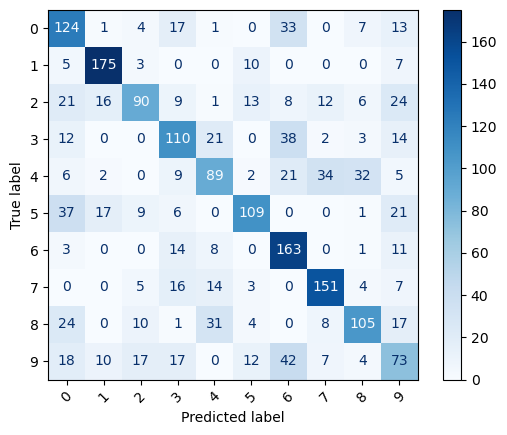

In [11]:
gnb = GaussianNB()

gnb.fit(Xtrain, Ytrain)

y_pred_nb = gnb.predict(Xtrain)

print("Naive Bayes Train Accuracy:", accuracy_score(Ytrain, y_pred_nb))

y_pred_nb = gnb.predict(Xtest)

print("Naive Bayes Test Accuracy:", accuracy_score(Ytest, y_pred_nb))
print(classification_report(Ytest, y_pred_nb))

cm = confusion_matrix(Ytest, y_pred_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.savefig('gnb_cm.png', bbox_inches='tight', dpi=300)

Pure MLP Test Accuracy: 0.7455
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       200
           1       0.90      0.91      0.90       200
           2       0.66      0.65      0.65       200
           3       0.70      0.68      0.69       200
           4       0.79      0.71      0.75       200
           5       0.82      0.82      0.82       200
           6       0.77      0.78      0.77       200
           7       0.87      0.81      0.84       200
           8       0.70      0.74      0.72       200
           9       0.55      0.53      0.54       200

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000

Pure MLP Train Accuracy: 1.0


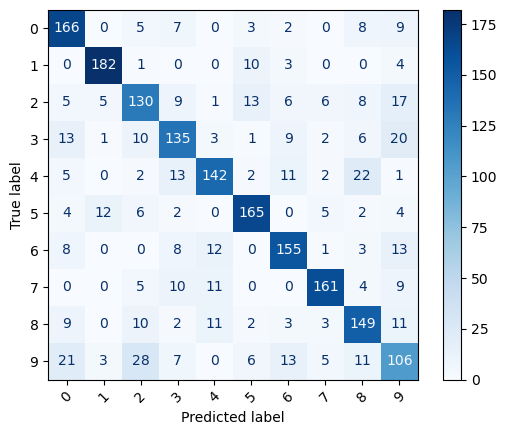

In [15]:
mlp = MLPClassifier(hidden_layer_sizes=(64,), activation='relu', max_iter=500, alpha=1e-4, validation_fraction=0.2)

mlp.fit(Xtrain, Ytrain)

pred_mlp = mlp.predict(Xtest)

print("Pure MLP Test Accuracy:", accuracy_score(Ytest, pred_mlp))
print(classification_report(Ytest, pred_mlp))

cm = confusion_matrix(Ytest, pred_mlp)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(cmap='Blues', xticks_rotation=45)

pred_mlp = mlp.predict(Xtrain)

print("Pure MLP Train Accuracy:", accuracy_score(Ytrain, pred_mlp))

SVM RBF Train Accuracy: 0.9763454317897372
Pure MLP Test Accuracy: 0.7745
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       200
           1       0.84      0.97      0.90       200
           2       0.65      0.64      0.64       200
           3       0.73      0.77      0.75       200
           4       0.84      0.69      0.76       200
           5       0.82      0.83      0.83       200
           6       0.88      0.78      0.82       200
           7       0.88      0.83      0.85       200
           8       0.77      0.81      0.79       200
           9       0.59      0.54      0.56       200

    accuracy                           0.77      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.78      0.77      0.77      2000



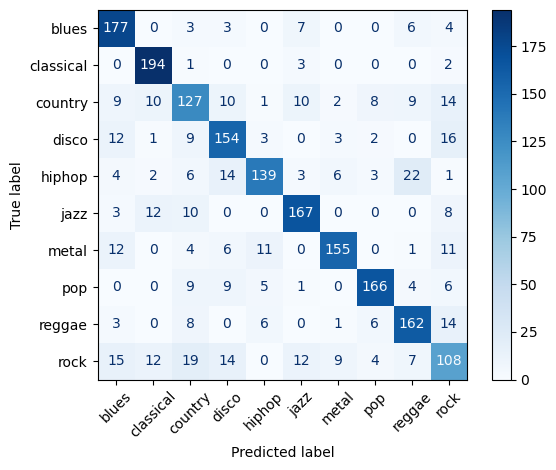

In [29]:
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)

svm_rbf.fit(Xtrain, Ytrain)

pred_svm = svm_rbf.predict(Xtrain)

print("SVM RBF Train Accuracy:", accuracy_score(Ytrain, pred_svm))

pred_svm = svm_rbf.predict(Xtest)

print("Pure MLP Test Accuracy:", accuracy_score(Ytest, pred_svm))
print(classification_report(Ytest, pred_svm))

cm = confusion_matrix(Ytest, pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.savefig('svmrbf_cm.png', bbox_inches='tight', dpi=300)

SVM RBF Train Accuracy: 0.9579474342928661
Pure MLP Test Accuracy: 0.7075
              precision    recall  f1-score   support

           0       0.72      0.73      0.73       200
           1       0.89      0.89      0.89       200
           2       0.52      0.56      0.54       200
           3       0.55      0.76      0.64       200
           4       0.83      0.68      0.74       200
           5       0.84      0.74      0.79       200
           6       0.87      0.72      0.79       200
           7       0.87      0.77      0.81       200
           8       0.78      0.73      0.75       200
           9       0.42      0.49      0.45       200

    accuracy                           0.71      2000
   macro avg       0.73      0.71      0.71      2000
weighted avg       0.73      0.71      0.71      2000



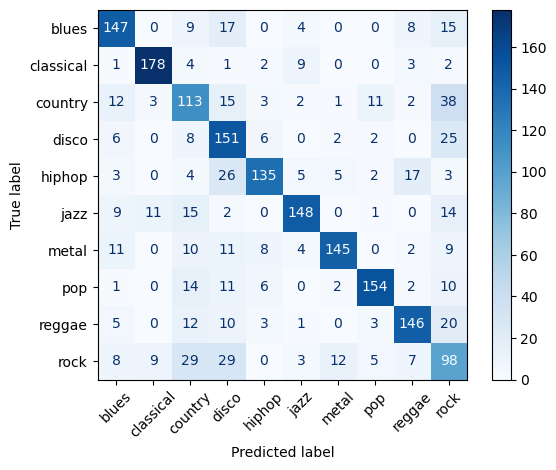

In [26]:
svm_poly = SVC(kernel='poly', degree=2, probability=True)

svm_poly.fit(Xtrain, Ytrain)

pred_svm = svm_poly.predict(Xtrain)

print("SVM RBF Train Accuracy:", accuracy_score(Ytrain, pred_svm))

pred_svm = svm_poly.predict(Xtest)

print("Pure MLP Test Accuracy:", accuracy_score(Ytest, pred_svm))
print(classification_report(Ytest, pred_svm))

cm = confusion_matrix(Ytest, pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(cmap='Blues', xticks_rotation=45)

SVM RBF Train Accuracy: 0.9573216520650814
Pure MLP Test Accuracy: 0.704
              precision    recall  f1-score   support

           0       0.76      0.70      0.73       200
           1       0.91      0.88      0.89       200
           2       0.70      0.55      0.62       200
           3       0.53      0.79      0.63       200
           4       0.86      0.61      0.72       200
           5       0.81      0.72      0.76       200
           6       0.87      0.71      0.78       200
           7       0.90      0.79      0.84       200
           8       0.77      0.73      0.75       200
           9       0.35      0.55      0.43       200

    accuracy                           0.70      2000
   macro avg       0.75      0.70      0.72      2000
weighted avg       0.75      0.70      0.72      2000



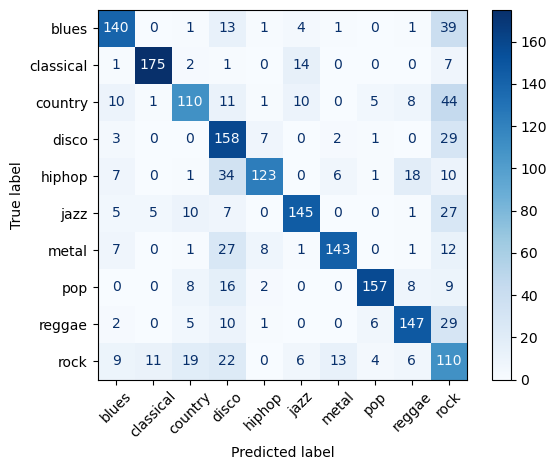

In [30]:
svm_poly = SVC(kernel='poly', degree=3, probability=True)

svm_poly.fit(Xtrain, Ytrain)

pred_svm = svm_poly.predict(Xtrain)

print("SVM RBF Train Accuracy:", accuracy_score(Ytrain, pred_svm))

pred_svm = svm_poly.predict(Xtest)

print("Pure MLP Test Accuracy:", accuracy_score(Ytest, pred_svm))
print(classification_report(Ytest, pred_svm))

cm = confusion_matrix(Ytest, pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(cmap='Blues', xticks_rotation=45)

SVM RBF Train Accuracy: 0.8530663329161452
Pure MLP Test Accuracy: 0.715
              precision    recall  f1-score   support

           0       0.61      0.84      0.71       200
           1       0.88      0.95      0.92       200
           2       0.53      0.57      0.55       200
           3       0.69      0.59      0.64       200
           4       0.71      0.62      0.66       200
           5       0.79      0.79      0.79       200
           6       0.81      0.83      0.82       200
           7       0.88      0.87      0.87       200
           8       0.69      0.64      0.66       200
           9       0.56      0.44      0.49       200

    accuracy                           0.71      2000
   macro avg       0.72      0.72      0.71      2000
weighted avg       0.72      0.71      0.71      2000



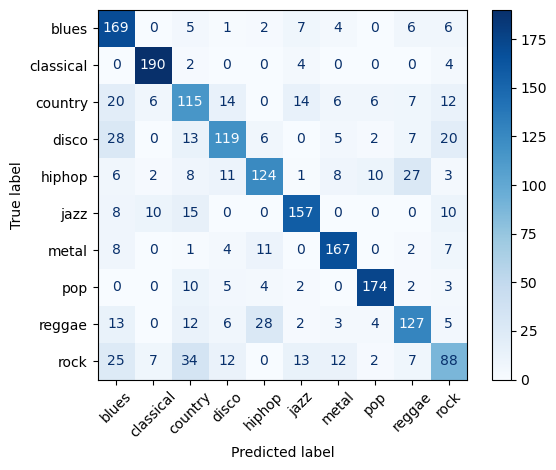

In [27]:
svm_lin = SVC(kernel='linear', probability=True)

Xtrain_norm = normalize(Xtrain)
Xtest_norm = normalize(Xtest)

svm_lin.fit(Xtrain_norm, Ytrain)

pred_svm = svm_lin.predict(Xtrain_norm)

print("SVM RBF Train Accuracy:", accuracy_score(Ytrain, pred_svm))

pred_svm = svm_lin.predict(Xtest_norm)

print("Pure MLP Test Accuracy:", accuracy_score(Ytest, pred_svm))
print(classification_report(Ytest, pred_svm))

cm = confusion_matrix(Ytest, pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(cmap='Blues', xticks_rotation=45)

SVM RBF Train Accuracy: 0.6607008760951188
Pure MLP Test Accuracy: 0.631
              precision    recall  f1-score   support

           0       0.50      0.78      0.61       200
           1       0.81      0.85      0.83       200
           2       0.45      0.46      0.46       200
           3       0.65      0.55      0.59       200
           4       0.67      0.56      0.61       200
           5       0.64      0.70      0.67       200
           6       0.76      0.81      0.78       200
           7       0.76      0.84      0.80       200
           8       0.56      0.46      0.50       200
           9       0.50      0.30      0.37       200

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.63      0.63      0.62      2000



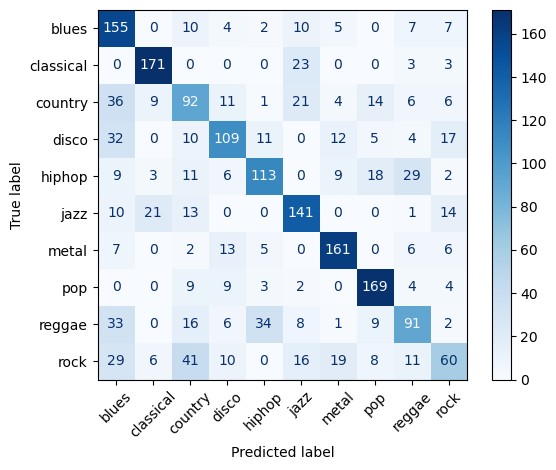

In [28]:
svm_sig = SVC(kernel='sigmoid', probability=True)

svm_sig.fit(Xtrain, Ytrain)

pred_svm = svm_sig.predict(Xtrain)

print("SVM RBF Train Accuracy:", accuracy_score(Ytrain, pred_svm))

pred_svm = svm_sig.predict(Xtest)

print("Pure MLP Test Accuracy:", accuracy_score(Ytest, pred_svm))
print(classification_report(Ytest, pred_svm))

cm = confusion_matrix(Ytest, pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(cmap='Blues', xticks_rotation=45)